### This notebook illustrates the use of the method on a real dataset. 

In [8]:
from SegmentACF import InitialiseLagList,getCentralLagArray,getWelchACF,getSelectionArray,getCorrection,getPhi,CalculateLags, GenerateCombs,plotCombs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import get_window
from obspy import UTCDateTime,Stream,Trace
from obspy.clients.fdsn import Client
from obspy.core import read
import os
import warnings
warnings.filterwarnings("ignore")

### Download a 6 months dataset using the obspy Client. This cell can be skipped.

In [16]:
pre_filt = (5E-5, 1E-4, 1E-3, 5E-2)  # Pre-filter coefficients for instrument response removal

ts = UTCDateTime("2010-01-01T00:00:00.000")  # Start time for waveform retrieval
te = UTCDateTime("2010-08-01T00:00:00.000")  # End time for waveform retrieval

client_name = 'IRIS'  # Default client for waveform retrieval
client = Client(client_name)



st = Stream()  # Stream object to store the retrieved waveform data
station_code = "BFO"  # Station code for the waveform data retrieval
channel = "VHZ"  # Here we only use the long periods to study the hum (LHZ = 1 sec sampling rate, VHZ = 0.1 sec sampling rate)
inv = client.get_stations(network="II", station=station_code, level="response")
station = inv[0][0]  # inventory station object
network = inv[0].code  # Network object from the inventory


location = station.channels[0].location_code  # Get the location code

# Here we loop 5 times to ensure we can retrieve the data because the client request may fail.
for i in range(5):

    try:
        st_tmp = client.get_waveforms(network, station_code, location ,channel, ts, te, attach_response=True)
        print(f"network : {network}, station code : {station_code}, location : {location}")

        # Merge the waveform data into the stream object
        st_tmp.merge(method=1,fill_value='interpolate')
        print(st_tmp)
        # If only one trace is present, remove the instrument response and append it to the stream object
        if len(st_tmp) == 1:
            for tr in st_tmp:
                tr.remove_response(inv,output='ACC', pre_filt=pre_filt)
                st += st_tmp
                break #Supposed to have a single trace in the stream object
            
        break  # Exit the loop if data retrieval is successful
                
    except Exception as e:
        pass
        print(f"Error retrieving data for station {station_code}")
        continue

os.makedirs("Data",exist_ok=True)  # Create a directory named 'Data' if it doesn't exist
st.write("Data/BFO_VHZ_2010-2010-6months.mseed", format="MSEED")  # Write the stream data to a MiniSEED file

network : II, station code : BFO, location : 00
1 Trace(s) in Stream:
II.BFO.00.VHZ | 2010-01-01T00:00:00.620300Z - 2010-08-01T00:00:00.347358Z | 0.1 Hz, 1831681 samples


### Data selection for the seismic hum : 

- Two kind of selections : amplitude selection based on the hum known amplitude
- Earthquake excited normal mode selection based on an EQ catalog

In [18]:
import SegmentACF
from importlib import reload
reload(SegmentACF)
from SegmentACF import InitialiseLagList,getCentralLagArray,getWelchACF,getSelectionArray,getCorrection,getPhi,getQ_P,getSelectionListFull,getFourierSubSegments
## First, we need to decide the lengths L and ell which will decide the numbers Q and P.
ts = UTCDateTime("2010-01-01T00:00:00.000")  # Start time for waveform retrieval
te = UTCDateTime("2012-01-01T00:00:00.000")  # End time for waveform retrieval
L = 2**14 # Around two days of data , when df = 0.1 Hz
ell = 2**10 # Around 12 hours of data, when df = 0.1 Hz

# We need to calculate the selection list to ultimately correct for zeta. Thus we first shrink the whole data set in sub-segments of length ell.

st = read("Data/BFO_VHZ_2010-2012.mseed")  # Read the MiniSEED file into a stream object
# Get the Fourier transforms of each sub-segment using vectorized function
psd_segments, freqs,segment_times_seconds = getFourierSubSegments(st[0], L,ell,no_pad=True)  # Get the Fourier transforms of each sub-segment using vectorized function


Total number of points : 1831681, Points used: 1825280
Number of sub-segment in the used data: 3563 
Number of sub-segments in the whole data: 3575


In [19]:
# Define the thresholds and frequency ranges for the different band
thresholds = [(1e-19, 5e-18),
             (1e-19, 3e-18),

            ]
freq_ranges = [(2e-3,7.5e-3),
               (1e-3,2e-3),
               ]

# Get the freq masks
freq_masks = [(freqs > fmin) & (freqs < fmax) for (fmin, fmax) in freq_ranges]

# Vectorized mean PSD per band and segment
mean_psds = np.array([
    psd_segments[:, mask].mean(axis=1)
    for mask in freq_masks
])  # shape (n_ranges, n_subseg)

selection_indexes = getSelectionListFull(ts,te,segment_times_seconds,mean_psds, thresholds,eqCatalog=False,max_mag=4.5)  # Get the selection list based on mean PSDs and thresholds 

Number of sub-segments discarded based on earthquake catalog: 0
Number of sub-segments discarded based on thresholds: 1098
Total number of sub-segments discarded: 1098
Proportion of discarded segments: 31.0 %


In [20]:
import SegmentACF
from importlib import reload
reload(SegmentACF)
from SegmentACF import InitialiseLagList,getCentralLagArray,getWelchACF,getSelectionArray,getCorrection,getPhi_batch,ProcessData


data = st[0].data  # Get the data from the first trace in the stream object

combs = GenerateCombs(ell, L)
big_window=np.sum(combs,axis=0) # This is the equialent window (it looks like a tukey window, mostly flat in the middle and tapering at the edges)
effective_sum= np.sum(big_window**2)  # Effective sum of the window, used for normalization
# Calculate the number of combs and segments in each comb
Q,P = getQ_P(len(st[0].data), L, ell)  # Get the number of segments Q and P based on the trace length and segment lengths.
npts_used = (L-ell//2)*Q
n_subseg = 2*(npts_used // ell)-1  # Number of sub-segments in the used data
Q=Q-1

#Initialise the selection list sigma (Eq 10 and text below)
selection_list_full = np.ones((n_subseg))  # Initialize the selection list with ones (all segments are initially selected)
for i in range(len(selection_list_full)):
    if i in selection_indexes:
        selection_list_full[i] = 0
        
# Initialise the lag lists, and correction factorss
central_lag_list=sorted(InitialiseLagList(ell,L))
central_lag_ij_array = getCentralLagArray(ell, L) 
Correction=getCorrection(Q,P,selection_list_full,central_lag_ij_array,central_lag_list)

selection_array, selection_array_i3 = getSelectionArray(Q,P, selection_list_full)

########### PROCESS THE DATA : Mute the p selected sub-segments ###########

phi,zeta_k= ProcessData(data,Q,ell,L,selection_array,selection_array_i3,Correction,central_lag_list,central_lag_ij_array)
phi*= 2 *(1/st[0].stats.sampling_rate)  # Apply the frequency bin correction and 2 sided spectrum factor

### PLOT

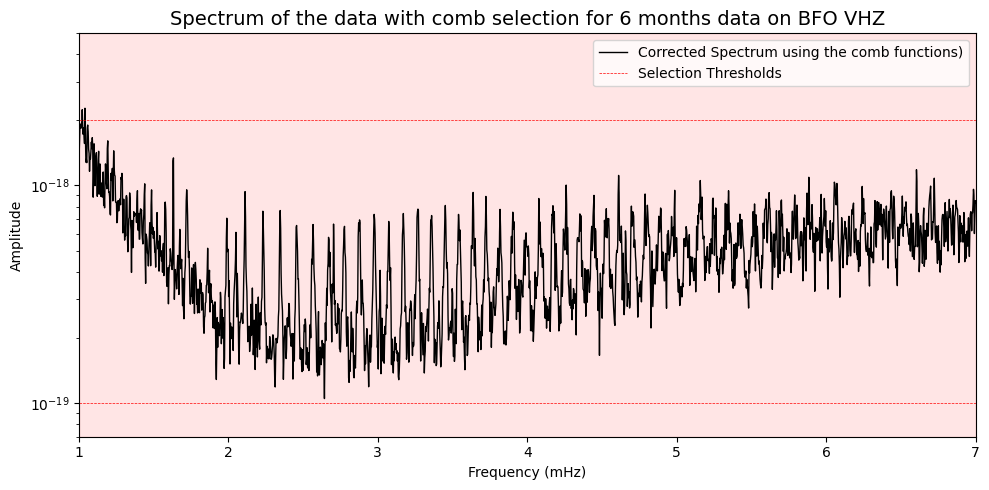

<IPython.core.display.Math object>

In [24]:
nfft = 2*L-1
spectrum = np.fft.rfft(phi)
freqs= np.fft.rfftfreq(nfft, st[0].stats.delta)  # Frequencies corresponding to the FFT
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.semilogy(freqs[:L]*1e3, np.abs(spectrum[:L])/effective_sum, color='black', lw=1, label='Corrected Spectrum using the comb functions)')
ax.set_title('Spectrum of the data with comb selection for 6 months data on BFO VHZ', fontsize=14)
ax.set_xlabel('Frequency (mHz)')
ax.set_ylabel('Amplitude')
ax.set_xlim(1, 7)
ax.set_ylim(0.7e-19,5e-18)

# Plot the thresholds

ax.axhline(1e-19, color='red', linestyle='--', lw=0.5, label=f'Selection Thresholds')
ax.axhline(2e-18, color='red', linestyle='--', lw=0.5, )
ax.fill_betweenx(ax.get_ylim(), 1, 7, color='red', alpha=0.1)
ax.legend()
plt.tight_layout()
plt.savefig("Figures/BFO2DaysRecovered.png", dpi=300)
plt.show()
from IPython.display import display, Math
display(Math(r'\large{\text{Note here that the result can be improved a lot by using more data than merely 6 months ! For the sake of smaller size file I had to limit the data to 6 months.}}'))